In [1]:
import os
import shutil
import torch
import collections
from torchvision import transforms,datasets
from __future__ import print_function, division
import os
import torch
import pylab
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import zipfile as zf
from fastai.vision import *
from fastai.metrics import error_rate
from pathlib import Path
from glob2 import glob
from sklearn.metrics import confusion_matrix

import pandas as pd
import numpy as np
import os
import zipfile as zf
import shutil
import re
import seaborn as sns
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")
 
plt.ion()   # interactive mode


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
import math
from PIL import Image
 
class Resize(object):
    """Resize the input PIL Image to the given size.
    Args:
        size (sequence or int): Desired output size. If size is a sequence like
            (h, w), output size will be matched to this. If size is an int,
            smaller edge of the image will be matched to this number.
            i.e, if height > width, then image will be rescaled to
            (size * height / width, size)
        interpolation (int, optional): Desired interpolation. Default is
            ``PIL.Image.BILINEAR``
    """
 
    def __init__(self, size, interpolation=Image.BILINEAR):
        # assert isinstance(size, int) or (isinstance(size, collections.Iterable) and len(size) == 2)
        self.size = size
        self.interpolation = interpolation
 
    def __call__(self, img):
        w,h = img.size
        
        min_edge = min(img.size)
        rate = min_edge / self.size
        
        new_w = math.ceil(w / rate)
        new_h = math.ceil(h / rate)
        
        return img.resize((new_w,new_h))


In [3]:
from google.colab import drive
drive.mount("/content/drive")
files = zf.ZipFile("/content/drive/My Drive/colab/dataset-resized.zip","r")
files.extractall()
files.close()

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
os.listdir(os.path.join(os.getcwd(),"dataset-resized"))

['plastic', '.DS_Store', 'trash', 'cardboard', 'glass', 'paper', 'metal']

In [0]:
def split_indices(folder,seed1):    
    n = len(os.listdir(folder))
    full_set = list(range(1,n+1))

    ## train indices
    random.seed(seed1)
    train = random.sample(list(range(1,n+1)),int(.8*n))

    ##  test
    test = list(set(full_set)-set(train))
    
    return(train,test)

## gets file names for a particular type of trash, given indices
    ## input: waste category and indices
    ## output: file names 
def get_names(waste_type,indices):
    file_names = [waste_type+str(i)+".jpg" for i in indices]
    return(file_names)    

## moves group of source files to another folder
    ## input: list of source files and destination folder
    ## no output
def move_files(source_files,destination_folder):
    for file in source_files:
        shutil.move(file,destination_folder)

In [0]:
## paths will be train/cardboard, train/glass, etc...
waste_types = ['cardboard','glass','metal','paper','plastic','trash']

## create destination folders for data subset and waste type
for waste_type in waste_types:
      folder = os.path.join('data','train',waste_type)
      if not os.path.exists(folder):
          os.makedirs(folder)
            
# if not os.path.exists(os.path.join('data','test')):
#     os.makedirs(os.path.join('data','test'))
for waste_type in waste_types:
      folder = os.path.join('data','test',waste_type)
      if not os.path.exists(folder):
          os.makedirs(folder)

In [0]:
## move files to destination folders for each waste type
for waste_type in waste_types:
    source_folder = os.path.join('dataset-resized',waste_type)
    train_ind,test_ind = split_indices(source_folder,1)
    
    ## move source files to train
    train_names = get_names(waste_type,train_ind)
    train_source_files = [os.path.join(source_folder,name) for name in train_names]
    train_dest = "data/train/"+waste_type
    move_files(train_source_files,train_dest)
    
    ## move source files to test
    test_names = get_names(waste_type,test_ind)
    test_source_files = [os.path.join(source_folder,name) for name in test_names]
    ## I use data/test here because the images can be mixed up
    test_dest = "data/test/"+waste_type
    move_files(test_source_files,test_dest)

In [0]:
## 数据集扩充
from PIL import ImageEnhance
import os
import numpy as np
from PIL import Image

def brightnessEnhancement(root_path,img_name):#亮度增强
    image = Image.open(os.path.join(root_path, img_name))
    enh_bri = ImageEnhance.Brightness(image)
    # brightness = 1.1+0.4*np.random.random()#取值范围1.1-1.5
    brightness = 1.5
    image_brightened = enh_bri.enhance(brightness)
    return image_brightened


def contrastEnhancement(root_path, img_name):  # 对比度增强
    image = Image.open(os.path.join(root_path, img_name))
    enh_con = ImageEnhance.Contrast(image)
    # contrast = 1.1+0.4*np.random.random()#取值范围1.1-1.5
    contrast = 1.5
    image_contrasted = enh_con.enhance(contrast)
    return image_contrasted

def rotation(root_path, img_name):
    img = Image.open(os.path.join(root_path, img_name))
    random_angle = np.random.randint(-2, 2)*90
    if random_angle==0:
     rotation_img = img.rotate(-90) #旋转角度
    else:
        rotation_img = img.rotate( random_angle)  # 旋转角度
    # rotation_img.save(os.path.join(root_path,img_name.split('.')[0] + '_rotation.jpg'))
    return rotation_img

def flip(root_path,img_name):   #翻转图像
    img = Image.open(os.path.join(root_path, img_name))
    filp_img = img.transpose(Image.FLIP_LEFT_RIGHT)
    # filp_img.save(os.path.join(root_path,img_name.split('.')[0] + '_flip.jpg'))
    return filp_img


def createImage(imageDir,saveDir):
   i=0
   for name in os.listdir(imageDir):
      i=i+1
      saveName="cesun"+str(i)+".jpg"
      saveImage=contrastEnhancement(imageDir,name)
      saveImage.save(os.path.join(saveDir,saveName))
      saveName1 = "flip" + str(i) + ".jpg"
      saveImage1 = flip(imageDir,name)
      saveImage1.save(os.path.join(saveDir, saveName1))
      saveName2 = "brightnessE" + str(i) + ".jpg"
      saveImage2 = brightnessEnhancement(imageDir, name)
      saveImage2.save(os.path.join(saveDir, saveName2))
      saveName3 = "rotate" + str(i) + ".jpg"
      saveImage = rotation(imageDir, name)
      saveImage.save(os.path.join(saveDir, saveName3))


In [0]:
for waste_type in waste_types:
    imageDir= '/content/data/train/'+waste_type #要改变的图片的路径文件夹
    saveDir= '/content/data/train/'+waste_type   #数据增强生成图片的路径文件夹
    createImage(imageDir,saveDir)


In [34]:
print(os.listdir('/content/data/train/'+'cardboard'))

['cardboard242.jpg', 'flip225.jpg', 'cesun134.jpg', 'brightnessE210.jpg', 'brightnessE242.jpg', 'flip10.jpg', 'cardboard357.jpg', 'cesun291.jpg', 'rotate40.jpg', 'rotate85.jpg', 'cardboard186.jpg', 'cardboard338.jpg', 'cardboard220.jpg', 'cesun99.jpg', 'cesun48.jpg', 'rotate4.jpg', 'brightnessE173.jpg', 'brightnessE139.jpg', 'cesun81.jpg', 'cesun273.jpg', 'cesun240.jpg', 'brightnessE194.jpg', 'flip43.jpg', 'rotate255.jpg', 'brightnessE265.jpg', 'cardboard379.jpg', 'cardboard175.jpg', 'brightnessE188.jpg', 'brightnessE298.jpg', 'brightnessE212.jpg', 'cesun215.jpg', 'cardboard213.jpg', 'brightnessE145.jpg', 'cardboard316.jpg', 'brightnessE60.jpg', 'brightnessE26.jpg', 'rotate104.jpg', 'rotate236.jpg', 'brightnessE128.jpg', 'cardboard200.jpg', 'flip231.jpg', 'flip119.jpg', 'rotate227.jpg', 'rotate155.jpg', 'cesun37.jpg', 'cesun232.jpg', 'flip285.jpg', 'cesun46.jpg', 'cardboard100.jpg', 'brightnessE104.jpg', 'cardboard171.jpg', 'flip206.jpg', 'cesun248.jpg', 'cesun169.jpg', 'brightnessE280

In [0]:
data_transform = transforms.Compose([
    Resize(84),
    transforms.CenterCrop(84),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.5,0.5,0.5],std = [0.5,0.5,0.5])
    
])
 
train_dataset = datasets.ImageFolder(root = '/content/data/train/',transform = data_transform)
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size = 16,shuffle = True,num_workers = 4)
 
test_dataset = datasets.ImageFolder(root = '/content/data/test/',transform = data_transform)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size = 16,shuffle = True,num_workers = 4)


In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        
        self.conv1 = nn.Conv2d(3,6,5)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(6,16,5)
        self.fc1 = nn.Linear(16 * 18 * 18,800)
        self.fc2 = nn.Linear(800,120)
        self.fc3 = nn.Linear(120,6)
        
    def forward(self,x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1,16 * 18 * 18)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x
 
net = Net()


In [44]:
import torch.optim as optim
 
cirterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(),lr = 0.004,momentum = 0.9)
 
for epoch in range(40):
    running_loss = 0.0
    print("epoch"+str(epoch))
    for i,data in enumerate(train_loader,0):
        inputs,labels = data
        inputs,labels = Variable(inputs),Variable(labels)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = cirterion(outputs,labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if i%315 == 0 and i!=0 :
            print('[%d %5d] loss: %.3f' % ((i/315-1)*315, i ,running_loss / 315))
            running_loss = 0.0
 
print('finished training!')


epoch0
[0   315] loss: nan


KeyboardInterrupt: ignored

In [43]:
correct = 0
total = 0
 
for data in test_loader:
    images,labels = data
    outputs = net(Variable(images))
    _,predicted = torch.max(outputs.data,1)
    total += labels.size(0)
    correct += (predicted == labels).sum()
 
print('Accuracy of the network on the  test images: %d %%' % (100 * correct / total))


Accuracy of the network on the  test images: 57 %


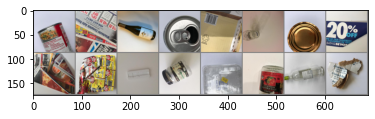

图像标签为：
GroundTruth:  metal paper glass metal cardboard glass metal paper paper paper plastic plastic plastic glass glass cardboard
预测结果为：
Predicted:  metal paper glass metal cardboard glass metal glass paper metal plastic plastic plastic metal paper glass


In [28]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision


def imshow(img):
  img = img/2+0.5 
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()


dataiter=iter(test_loader)
images,labels=dataiter.next()


imshow(torchvision.utils.make_grid(images))
print("图像标签为：")
print('GroundTruth: ', ' '.join('%5s'% waste_types[labels[j]] for j in range(16)))
outputs = net(images)
predicted=torch.max(outputs,1)[1].numpy()
print("预测结果为：")
print('Predicted: ', ' '.join('%5s'% waste_types[predicted[j]] for j in range(16)))
